In [1]:
import torch
import numpy as np
from pathlib import Path
from PIL import Image
from torchvision.transforms import Normalize
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from utils import load_encoders

# filepath: REG/extract_dinov2_embeddings.py


CLIP_DEFAULT_MEAN = (0.48145466, 0.4578275, 0.40821073)
CLIP_DEFAULT_STD = (0.26862954, 0.26130258, 0.27577711)

def preprocess_raw_image(x: torch.Tensor, enc_type: str) -> torch.Tensor:
    resolution = x.shape[-1]
    if 'clip' in enc_type:
        x = x.float() / 255.0
        x = torch.nn.functional.interpolate(x, 224 * (resolution // 256), mode='bicubic', align_corners=False)
        x = Normalize(CLIP_DEFAULT_MEAN, CLIP_DEFAULT_STD)(x)
    elif 'mocov3' in enc_type or 'mae' in enc_type:
        x = x.float() / 255.0
        x = Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)(x)
    elif 'dinov2' in enc_type:
        x = x.float() / 255.0
        x = Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)(x)
        x = torch.nn.functional.interpolate(x, 224 * (resolution // 256), mode='bicubic', align_corners=False)
    elif 'dinov1' in enc_type:
        x = x.float() / 255.0
        x = Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)(x)
    elif 'jepa' in enc_type:
        x = x.float() / 255.0
        x = Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)(x)
        x = torch.nn.functional.interpolate(x, 224 * (resolution // 256), mode='bicubic', align_corners=False)
    return x

def load_image_uint8(path: Path) -> torch.Tensor:
    img = Image.open(path).convert("RGB")
    arr = np.array(img)  # HWC, uint8
    ten = torch.from_numpy(arr).permute(2, 0, 1).to(torch.uint8)  # CHW
    return ten.unsqueeze(0)  # 1,C,H,W



/root/stuff/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enc_type = "dinov2-vit-b"
resolution = 256

# Resolve image path
image_path = Path("REG/dataset/images/00000/img00000000.png")
if not image_path.exists():
    image_path = Path("dataset/images/00000/img00000000.png")
if not image_path.exists():
    raise FileNotFoundError("Test image not found at REG/dataset/... or dataset/...")

# Load encoder
encoders, encoder_types, architectures = load_encoders(enc_type, device, resolution)
encoder = encoders[0].to(device).eval()
encoder_type = encoder_types[0]

# Load and preprocess image (uint8 -> float + norm + resize like train.py)
raw_image = load_image_uint8(image_path).to(device)  # [1,3,H,W] uint8
x = preprocess_raw_image(raw_image, encoder_type)     # [1,3,224,224] float



Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Now you are using the dinov2-vit-b as the aligning model


In [3]:
with torch.no_grad():
    feats = encoder.forward_features(x)
    if 'dinov2' in encoder_type:
        patch_tokens = feats['x_norm_patchtokens']       # [B, N, C]
        cls_token = feats['x_norm_clstoken']             # [B, C]
        dense_tokens = torch.cat([cls_token.unsqueeze(1), patch_tokens], dim=1)  # [B, 1+N, C]
    else:
        raise RuntimeError(f"Unsupported encoder_type: {encoder_type}")

print(f"cls_token shape: {cls_token.shape}")          # [1, C]
print(f"dense_tokens shape: {dense_tokens.shape}")    # [1, 1+N, C]

cls_token shape: torch.Size([1, 768])
dense_tokens shape: torch.Size([1, 257, 768])


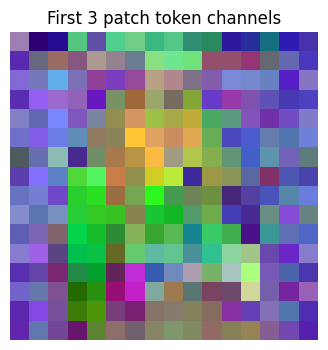

In [10]:
import numpy as np

import matplotlib.pyplot as plt

# Select first 3 channels and reshape to patch grid (H, W, 3)
B, N, C = patch_tokens.shape
hw = int(round(N ** 0.5))
assert hw * hw == N, f"Patch count {N} is not a perfect square."
pt3 = patch_tokens[0, :, 6:9].detach().cpu().numpy().reshape(hw, hw, 3)
# pt3 = patch_tokens.mean(2).detach().cpu().numpy().reshape(hw, hw)  # For grayscale

# Normalize per-channel to [0, 1] for visualization
pt3_norm = pt3.copy()
for c in range(3):
    ch = pt3_norm[..., c]
    ch_min, ch_max = ch.min(), ch.max()
    if ch_max > ch_min:
        pt3_norm[..., c] = (ch - ch_min) / (ch_max - ch_min)
    else:
        pt3_norm[..., c] = 0.5

plt.figure(figsize=(4, 4))
plt.imshow(pt3_norm)
plt.title("First 3 patch token channels")
plt.axis("off")
plt.show()

In [ ]:
# Downsample patch_tokens from 16x16 (256) to 8x8 (64) via bilinear interpolation
B, N, C = patch_tokens.shape
assert hw * hw == N, f"Patch tokens count ({N}) != hw^2 ({hw}^2)"

pt_grid = patch_tokens.view(B, hw, hw, C).permute(0, 3, 1, 2)  # [B, C, 16, 16]
pt_grid_8 = torch.nn.functional.interpolate(pt_grid, size=(8, 8), mode='bilinear', align_corners=False)
patch_tokens_8x8 = pt_grid_8.permute(0, 2, 3, 1).reshape(B, 8 * 8, C)  # [B, 64, C]

print(f"patch_tokens_8x8 shape: {patch_tokens_8x8.shape}")

# Plot first 3 channels (matching selection strategy from cell 3: channels 6:9)
pt3_8 = patch_tokens_8x8[0, :, 6:9].detach().cpu().numpy().reshape(8, 8, 3)

# Normalize per-channel to [0, 1] for visualization
pt3_8_norm = pt3_8.copy()
for c in range(3):
    ch = pt3_8_norm[..., c]
    ch_min, ch_max = ch.min(), ch.max()
    pt3_8_norm[..., c] = (ch - ch_min) / (ch_max - ch_min) if ch_max > ch_min else 0.5

plt.figure(figsize=(3, 3))
plt.imshow(pt3_8_norm)
plt.title("8x8 patch token channels (6:9)")
plt.axis("off")
plt.show()

patch_tokens_8x8 shape: torch.Size([1, 64, 768])


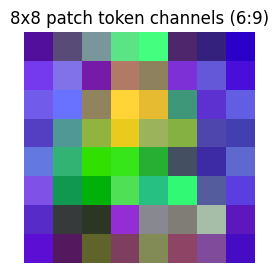

In [13]:
# Downsample patch_tokens from 16x16 (256) to 8x8 (64) via bilinear interpolation
B, N, C = patch_tokens.shape
assert hw * hw == N, f"Patch tokens count ({N}) != hw^2 ({hw}^2)"

pt_grid = patch_tokens.view(B, hw, hw, C).permute(0, 3, 1, 2)  # [B, C, 16, 16]
pt_grid_8 = torch.nn.functional.interpolate(pt_grid, size=(8, 8), mode='bilinear', align_corners=False)
patch_tokens_8x8 = pt_grid_8.permute(0, 2, 3, 1).reshape(B, 8 * 8, C)  # [B, 64, C]

print(f"patch_tokens_8x8 shape: {patch_tokens_8x8.shape}")

# Plot first 3 channels (matching selection strategy from cell 3: channels 6:9)
pt3_8 = patch_tokens_8x8[0, :, 6:9].detach().cpu().numpy().reshape(8, 8, 3)

# Normalize per-channel to [0, 1] for visualization
pt3_8_norm = pt3_8.copy()
for c in range(3):
    ch = pt3_8_norm[..., c]
    ch_min, ch_max = ch.min(), ch.max()
    pt3_8_norm[..., c] = (ch - ch_min) / (ch_max - ch_min) if ch_max > ch_min else 0.5

plt.figure(figsize=(3, 3))
plt.imshow(pt3_8_norm)
plt.title("8x8 patch token channels (6:9)")
plt.axis("off")
plt.show()